# Import 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import zeta
from scipy import integrate, interpolate
import pandas as pd
import time
import pickle
from scipy.interpolate import interp1d, RegularGridInterpolator
import equations_and_constants as ec
from scipy.integrate import quad

# Constants & equations

## Fundamental Constants

In [3]:
# Unit conversions
hbar = 6.582*10**-16 #eV s
MeVtoHz = 10**6/hbar
HztoMeV = hbar/10**6
kb =  1.380649*10**-23 #J/K 
charge = 1.602176634*10**-19 #C
MeVtoJ = 10**6*charge
JtoMeV = 10**-6/charge
KtoMeV = kb*JtoMeV
eVtoMeV = 10**-6
c = 2.9979*10**8 #m/s
MeVtoinversecm = 10**6/(hbar*c*100)

# Masses, all in MeV
# Leptons
m_e, m_mu, m_tau = 0.510,105.7,1776.9
# Quarks
m_u, m_d, m_s, m_c, m_b, m_t = 2.3,4.8,95,1290,4180,173500
# Gauge bosons
m_W, m_Z, m_H = 80400,91200,125090
#Baryons
m_p, m_n = 938,939
# Mesons
m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega = 134.9766,139.570,497.614,493.678,647.862,957.78,775.11,775.26,782.65
masses = np.sort([m_e, m_mu, m_tau, m_u, m_d, m_s, m_c, m_b, m_t, m_W, m_Z, m_H, m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega])
discontinuity_masses = np.sort([m_mu, m_tau, m_c, m_b, m_t, m_W, m_Z, m_H, m_pi0, m_pipm])

# Other fundamental constants, all in MeV unless otherwise noted
Gf = 1.166 * 10**-5 *10**-6 #MeV**-2
grav = (1.22*10**22)**-2 #MeV**-2 
thetaW = np.arcsin(np.sqrt(0.2229))
fine_structure = 7.297352*10**-3
eta_B = 6*10**-10 #baryon asymmetry
f_pi = 131 # for pion channel decay
# QCD Transition temperature and width
T_qcd = 170 
w_qcd = 10
h=0.7 # hubble factor
omega_dm_hsq = 0.120 #omega_m*h^2, planck 2018, error is 0.001
H100 =  100*3.24*10**-20*HztoMeV
Tcmb = 2.725*KtoMeV

## Relativistic Degrees of Freedom: From Amol's diluton code

In [4]:
def compute_SM_relativistic_dof(T):
    """Calculate the relativistic degrees of freedom for the purposes of 
    computing the energy density. Valid up to arbitrarily high temperatures,
    and down to weak decoupling. Makes the approximation of g=0 once m>T."""
    #.....Enter particle characteristics, in the following order of particles: 
    #.....Leptons: e,mu,tau; Quarks: u,d,s,c,b,t; Gauge bosons (and Higgs): W+-,Z,H;
    #.....Baryons: p,n; Mesons: pi0,pi+-,K0,K+-,eta,eta',rho+-,rho0,omega
    #.....Particle masses in MeV
    masses = [m_e, m_mu, m_tau, m_u, m_d, m_s, m_c, m_b, m_t,m_W, m_Z,m_H,m_p,m_n,
                      m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega]

    # stat = ['f','f','f','f','f','f','f','f','f','b','b','b',
    #         'f','f','b','b','b','b','b','b','b','b','b']
    #.....Particle class: 'l' for lepton, 'q' for quark, 'g' for gauge bosons (and Higgs), 'h' for hadron
    particle_classes = ['l','l','l','q','q','q','q','q','q','g','g','g',
             'h','h','h','h','h','h','h','h','h','h','h']
    gdofs = [4.,4.,4.,12.,12.,12.,12.,12.,12.,6.,3.,1., 
            4.,4.,1.,2.,2.,2.,1.,1.,6.,3.,3.]

    #.....Statistical weights for massless or nearly massless particles (photons, neutrinos, gluons)
    gphot = 2. # Photon dofs
    gnuact = 3*2 # Active neutrino dofs: prior to weak decoupling 
    ggl = 16./(np.exp((T_qcd-T)/w_qcd)+1.) # Gluon dofs
    g_tot = gphot+gnuact+ggl
    
    # Massive particles approximation: simply set g_rel=0 when m<T. 
    # Also account for QCD phase transition
    for mass, particle_class, gdof in zip(masses, particle_classes, gdofs):
        if mass>T:
            gdof = 0
        if(particle_class == 'q'): 
            if T>0.1*T_qcd:
                gdof=gdof/(np.exp((T_qcd-T)/w_qcd)+1.)
            # avoid overflow warnings 
            else:
                gdof=0
        elif(particle_class == 'h'):
            if T<10*T_qcd:
                gdof=gdof/(np.exp((T-T_qcd)/w_qcd)+1.)
            # avoid overflow warnings
            else:
                gdof=0
        g_tot += gdof
        
    return g_tot

## Neutrino thermal scattering coefficients

#### <10 GeV

In [11]:
# Data from hep-ph/0612182 (sec.3)                   
# M1/MeV: 0.01                                       
# T/MeV: 10^4 ... 1.0 [100 values]                   
# q/T:  0.25 ... 12.5 [50 values]                    
# Columns:                                           
# T/MeV q/T hat{I_Q} 
# Explanatory file: http://www.laine.itp.unibe.ch/neutrino-rate/imSigma.pdf
# Note: The scattering rate is Gamma = hat{I_Q}*T^4*p*G_F^2

scattering_coeffs_dict = {}
for i, flavor in enumerate(['electron', 'muon', 'tau']):
    df = pd.read_table("/home/jakespisak/Fuller/sterile_sterile_interactions/thermal_neutrino_scattering_coefficients/hatIQ_M001_alpha{}_Fermi.dat".format(i+1),
                         skiprows=6, header=None, delim_whitespace=True, names=['T/MeV', 'q/T', 'hat{I_Q}'])
    qoverTdomain = np.array(df.loc[df['T/MeV'] == 10000.00, 'q/T'])
    Tdomain = np.flip(np.array(df.loc[df['q/T'] == 1.00, 'T/MeV']))
    coefficients = np.flip(np.array(df['hat{I_Q}']).reshape((len(Tdomain), len(qoverTdomain))), axis=0)
    scattering_coeffs_dict[flavor] = interpolate.RegularGridInterpolator((Tdomain, qoverTdomain), coefficients, bounds_error=True, fill_value=None)
    
def scattering_coeffs(T, p, flavor):
    """Active neutrino thermal scattering coefficients"""
    if np.isscalar(T) and np.isscalar(p):
        return scattering_coeffs_dict[flavor]([T, p/T])[0]
    else:
        results = []
        assert len(T) == len(p)
        for Tval, pval in zip(T, p):
            results.append(scattering_coeffs_dict[flavor]([Tval, pval/Tval])[0])
        return np.array(results)

#### 5 to 150 GeV

In [12]:
# Data from https://arxiv.org/abs/1605.07720                  
# T/Gev	k/T	\Gamma/T                               
# Explanatory file: http://www.laine.itp.unibe.ch/production-midT/

df = pd.read_table("/home/jakespisak/Fuller/fortepiano_public/thermal_neutrino_scattering_coefficients/Gamma_5to150GeV.dat",
                     skiprows=1, header=None, delim_whitespace=True, names=['T/Gev', 'k/T', '\Gamma/T'])
koverTdomain = np.array(df.loc[df['T/Gev'] == 150, 'k/T'])
Tdomain = np.flip(np.array(df.loc[df['k/T'] == 1.0, 'T/Gev']))*10**3 #convert to MeV
coefficients = np.flip(np.array(df['\Gamma/T']).reshape((len(Tdomain), len(koverTdomain))), axis=0)
interp5to150Gev = interpolate.RegularGridInterpolator((Tdomain, koverTdomain), coefficients, bounds_error=True, fill_value=None)

In [13]:
def active_scattering_rate(p, T, flavor):
    """The active neutrino scattering rate. Valid from 1 Mev to 150 Gev"""
    changeover = 7*10**3 
    if np.isscalar(T) and np.isscalar(p):
        if T< changeover:
            return scattering_coeffs_dict[flavor]([T, p/T])[0]*Gf**2*p*T**4
        else:
            return interp5to150Gev([T, p/T])[0]*T 
    
    else:
        results = []
        assert len(T) == len(p)
        for Tval, pval in zip(T, p):
            if Tval < changeover:
                results.append(scattering_coeffs_dict[flavor]([Tval, pval/Tval])[0]*Gf**2*pval*Tval**4)
            else:
                results.append(interp5to150Gev([Tval, pval/Tval])[0]*Tval)
        return np.array(results)

#### Consistency check

In [23]:
temp = 10*10**3
flavor='electron'
poverT = 1
print(interp5to150Gev([temp, poverT])*temp)
print(scattering_coeffs_dict[flavor]([temp, poverT])*Gf**2*poverT*temp**5)

[0.14777838]
[0.13897653343200003]


# Numerical Boltzmann Calculation

In [80]:
def integrand(Tprime, p, Tf, theta, ms, flavor, antineutrino=False, merle_simplification=False):
    momentum = p*(Tprime/Tf)*(ec.compute_SM_relativistic_dof(Tprime)/ec.compute_SM_relativistic_dof(Tf))**(1/3.0)
#    print(ec.fermi_dirac(momentum, Tprime, eta=0))
#    print(ec.h(p, T, theta, ms, flavor, antineutrino=False))
    return ec.fermi_dirac(momentum, Tprime, eta=0)*ec.h(momentum, Tprime, theta, ms, flavor, antineutrino, merle_simplification)

def solve(p, Ti, Tf, theta, ms, flavor, discontinuity_masses, antineutrino=False, merle_simplification=False):
    limits = np.sort([m for m in discontinuity_masses if m < Ti and m > Tf] + [Ti, Tf])[::-1]
    total_result, total_err = 0, 0
    for i in range(len(limits)-1):
        result, err = quad(integrand, limits[i], limits[i+1], args=(p, Tf, theta, ms, flavor, antineutrino, merle_simplification))
        total_result += result
        total_err += err
    return total_result, total_err

### Check the integrand

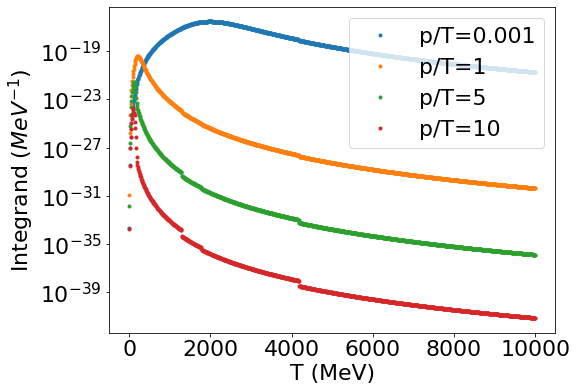

In [136]:
Ti=10**4
Tf=1
Tprimes = np.linspace(Tf, Ti, 1000)
theta=np.sqrt(2*10**-8)/2
ms=2*10**-3
antineutrino=False
merle_simplification=True
flavor='electron'

plt.figure(figsize=(8,6))
for poverT in [0.001, 1, 5, 10]:
    integrands = [integrand(Tp, poverT*Tf, Tf, theta, ms, flavor, antineutrino, merle_simplification) for Tp in Tprimes]
    plt.semilogy(Tprimes, integrands, '.', label="p/T={}".format(poverT))
plt.ylabel(r"Integrand ($MeV^{-1}$)")
plt.xlabel("T (MeV)")
plt.legend()
plt.show()

In [143]:
poverT = 0.001
Tf=1
Ti = 6000
solve(poverT*Tf, Ti, Tf, theta, ms, flavor, discontinuity_masses, antineutrino=False, merle_simplification=True)

(-3.9538498011598496e-14, 1.1663674855724325e-17)

### Solve

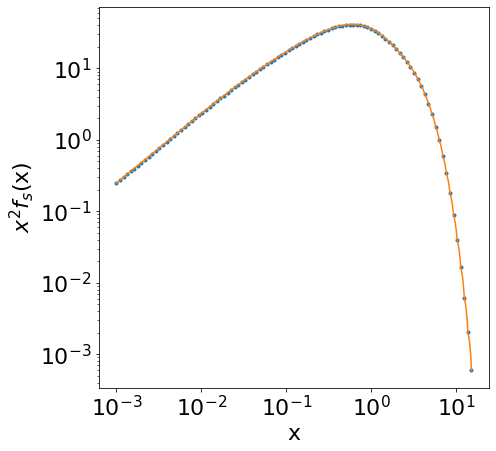

fint=1.5487916263895584e-16, err=2.710265967304563e-16


In [150]:
theta=np.sqrt(2*10**-8)/2
ms=2*10**-3
antineutrino=False
merle_simplification=True
flavor='electron'
Ti = 6*10**3
Tf = 1

poverT_min, poverT_max = 0.001, 15
poverTs = np.logspace(np.log10(poverT_min), np.log10(poverT_max), 100)
f = []
for p in poverTs*Tf:
    result, err = solve(p, Ti, Tf, theta, ms, flavor, discontinuity_masses, antineutrino, merle_simplification)
    f.append(-1*result)

# Interpolate and integrate the results
f_integrand = interp1d(poverTs, f, kind='linear')
plt.figure(figsize=(7,7))
plt.loglog(poverTs, np.array(f)*poverTs**2, '.')
smoothed_poverTs = np.logspace(np.log10(poverT_min), np.log10(poverT_max), 1000)
plt.loglog(smoothed_poverTs, f_integrand(smoothed_poverTs)*smoothed_poverTs**2)
plt.xticks(np.logspace(-3, 1, 5))
plt.ylabel(r"$x^2 f_s$(x)")
plt.xlabel("x")
plt.show()

fint, err = quad(f_integrand, poverT_min, poverT_max)
print("fint={}, err={}".format(fint, err))

In [43]:
# Convert to omega_m
T0 = Tcmb*(ec.compute_SM_relativistic_dof(Tcmb)/ec.compute_SM_relativistic_dof(Tf))**(1/3.0)
print("Multiplying by two to include antineutrinos")
ndens = ec.fint_to_n(2*fint, T0)
print("Number of neutrinos per cm^-3 {}".format(ndens*MeVtoinversecm**3))

m_relic=ms
print("omega h^2 ={} for m_relic={} keV".format(ec.rho_to_omegahsq(m_relic*ndens), 10**3*m_relic))

Multiplying by two to include antineutrinos
Number of neutrinos per cm^-3 1.546954662878369e-15
omega h^2 =2.941885793837374e-16 for m_relic=2.0 keV


### Compare to fortepiano results

In [ ]:
from python.fortepianoOutput import FortEPiaNORun

# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.01
}

# Analytic results
T = np.logspace(0, 3, 400)
sid = ec.SID_rate(ec.avg_p(T), T, params["theta"], params["m4"], 'electron')

#thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate', c='b')
ax1.loglog(1/T, sid*MeVtoHz, label=r"$\Gamma_{SID}$(p=3kT, T)", c='b', ls='--')
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
# if thermalized:
#     ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Rate (Hz)")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)
ax1.yaxis.label.set_color('b')
ax1.tick_params(axis='y', colors='b')

# Fortepiano results
yref =7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
labels = [r"$\rho_e$(p=3kT)", r"$\rho_\mu$(p=3kT)", r"$\rho_\tau$(p=3kT)", r"$\rho_s$(p=3kT)"]
lines = ["dotted", "dotted", "dotted", "dashdot"]
for i, flav, label, ls in zip(range(4), flavs, labels, lines):
    if flav not in ['mu', 'tau']:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
        rho_ij = [r for _, r in sorted(zip(x, rho_ij))]
        x = sorted(x)
        ax2.semilogx(x, rho_ij, c='r', ls=ls, label=label)
ax2.set_ylabel(r"Fortepiano $\rho$")            
ax2.legend(loc=4)
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')
plt.xlim(10**-3, 1)
plt.title(r"$m_s={} MeV, \theta={}$".format(params['m4'], params['theta']))
plt.show()

# Nu5 from SID to Nu4: approximate solution

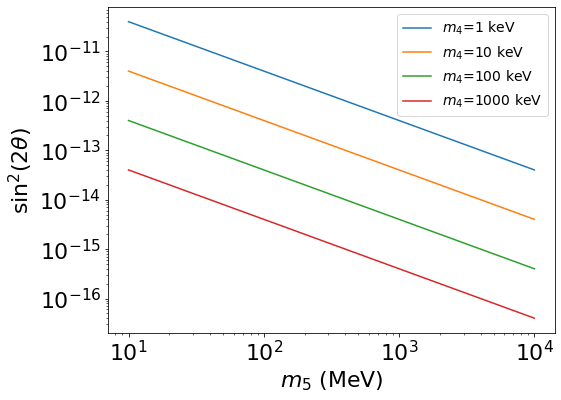

In [17]:
def sinsq2theta_from_dw54(m_4, m_5):
    """m_4, m_5 in MeV"""
    return (m_5/m_4)*(omega_dm_hsq/0.3)*10**-10*(m_5/0.1)**-2


m_4_array = np.logspace(-3, 0, 4)
m_5 = np.logspace(1, 4, 100)
plt.figure(figsize=(8,6))
for m_4 in m_4_array:
    plt.loglog(m_5, sinsq2theta_from_dw54(m_4, m_5), label=r"$m_4$={} keV".format(int(m_4*10**3)))
plt.legend(fontsize=14)
plt.ylabel(r"$\sin^2(2\theta)$")
plt.xlabel(r"$m_5$ (MeV)")
plt.show()

# Compute and save the lepton integral results (don't need to run every time)

In [ ]:
def lepton_integral(n, x):
    """Occupation number integrals"""
    integrand = lambda y, x: y**n/(np.exp(np.sqrt(x**2 + y**2))-1)
    # Need to distinguish between scalars and arrays
    if np.isscalar(x):
        result, _ = integrate.quad(integrand, 0, 100, args=(x))
    else:
        result = [integrate.quad(integrand, 0, 100, args=(x_val))[0] for x_val in x]
    return result

# Compute the integral
data_dic = {}
for n in [2,3]:
    x_domain = np.logspace(-2, 2, 1000)
    data = lepton_integral(n, x_domain)
    x_domain_extended = np.concatenate(([0], x_domain, [np.inf]))
    data_extended = np.concatenate(([data[0]], data, [0]))
    data_dic[n] = {
        "x":x_domain_extended,
        "value":data_extended
    }
with open("/home/jakespisak/Fuller/sterile_sterile_interactions/lepton_integral/lepton_integrals.pkl", 'wb') as f:
    pickle.dump(data_dic, f)

# Comparison to fortepiano

Sterile Garrazio benchmark

                & 1.47836 & 1.01618 & 1.01470 & 1.01465 & 1.01038 & 4.05590\\


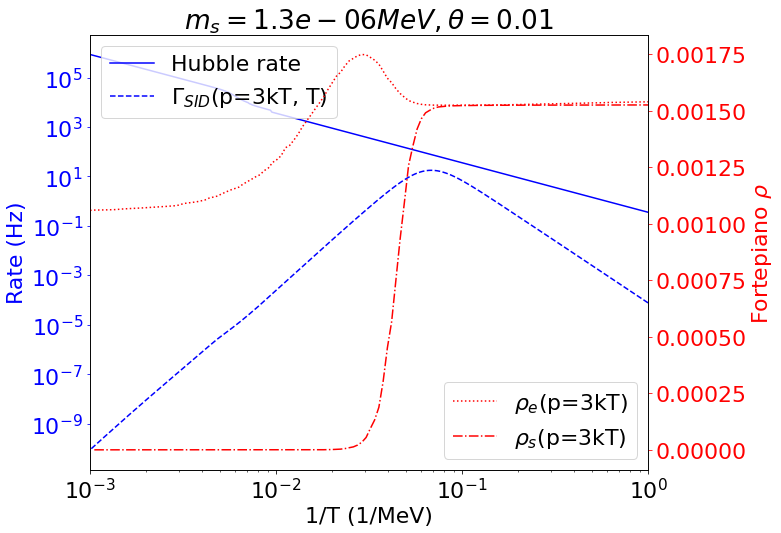

In [38]:
from python.fortepianoOutput import FortEPiaNORun

# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.01
}

# Analytic results
T = np.logspace(0, 3, 400)
sid = ec.SID_rate(ec.avg_p(T), T, params["theta"], params["m4"], 'electron')

#thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate', c='b')
ax1.loglog(1/T, sid*MeVtoHz, label=r"$\Gamma_{SID}$(p=3kT, T)", c='b', ls='--')
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
# if thermalized:
#     ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Rate (Hz)")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)
ax1.yaxis.label.set_color('b')
ax1.tick_params(axis='y', colors='b')

# Fortepiano results
yref =7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
labels = [r"$\rho_e$(p=3kT)", r"$\rho_\mu$(p=3kT)", r"$\rho_\tau$(p=3kT)", r"$\rho_s$(p=3kT)"]
lines = ["dotted", "dotted", "dotted", "dashdot"]
for i, flav, label, ls in zip(range(4), flavs, labels, lines):
    if flav not in ['mu', 'tau']:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
        rho_ij = [r for _, r in sorted(zip(x, rho_ij))]
        x = sorted(x)
        ax2.semilogx(x, rho_ij, c='r', ls=ls, label=label)
ax2.set_ylabel(r"Fortepiano $\rho$")            
ax2.legend(loc=4)
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')
plt.xlim(10**-3, 1)
plt.title(r"$m_s={} MeV, \theta={}$".format(params['m4'], params['theta']))
plt.show()

Sterile Garrazio benchmark e3

                & 1.50137 & 1.01721 & 1.01656 & 1.01654 & 0.57268 & 3.62298\\


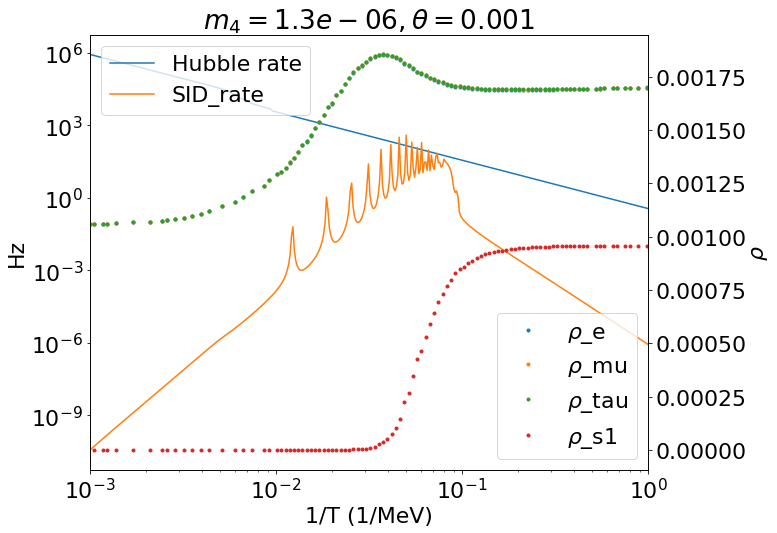

In [36]:
# Model parameters
# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.001,
}

# Analytic results
T = np.logspace(0, 3, 400)
sid = ec.SID_rate_integrated(T, params["theta"], params["m4"], 'electron')

#thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate')
ax1.loglog(1/T, sid*MeVtoHz, label="SID_rate")
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
# if thermalized:
#     ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Hz")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)

# Fortepiano results
yref = 7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark_e3/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
for i, flav in zip(range(4), flavs):
    if i == 4:
        rho_ij = np.zeros(len(x))
    else:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
    ax2.semilogx(x, rho_ij, '.', label=r"$\rho$_{}".format(flav))
ax2.set_ylabel(r"$\rho$")            
ax2.legend(loc=4)
plt.xlim(10**-3, 1)
plt.title(r"$m_4={}, \theta={}$".format(params['m4'], params['theta']))
plt.show()

# Results from Parameter Scan

In [36]:
m5_log_min, m5_log_max = 0, 5
m5_domain = np.logspace(m5_log_min, m5_log_max, 50)
theta_log_min, theta_log_max = -10, 0
theta_domain = np.logspace(theta_log_max, theta_log_min, 50)
tau_bbn = 10 #seconds: from Vincent's paper
sid_results = {
"thermalized": [],
"T_freezeout": [],
"T_thermal": [],
"not_boltzmann_supressed":[],
"decay_before_BBN":[],
"m4_required":[],
"lifetime":[]
}

start = time.time()
for theta in theta_domain:
    for key in sid_results:
        sid_results[key].append([])
    for m5 in m5_domain:
        thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**5, 1, theta, m5, 'electron', antineutrino=False, num_T=1000)
        sid_results['thermalized'][-1].append(thermalized)
        sid_results['T_freezeout'][-1].append(T_freezeout)
        sid_results['T_thermal'].append(T_thermal)
        if thermalized:
            sid_results['not_boltzmann_supressed'][-1].append(T_freezeout>m5)
        else:
            sid_results['not_boltzmann_supressed'][-1].append(True) #Not boltzmann supressed if it never thermalizes
        sid_results['decay_before_BBN'][-1].append(ec.lifetime(m5, theta)<tau_bbn)
        sid_results['m4_required'][-1].append(ec.m4_dark_matter(m5, ec.lifetime(m5, theta), 1, 1)) #relativistic DOFs don't matter, since Tf4=Tf5
        sid_results['lifetime'][-1].append(ec.lifetime(m5, theta)) 
        
print(time.time()-start)

253.042724609375


## Conditions that must be met

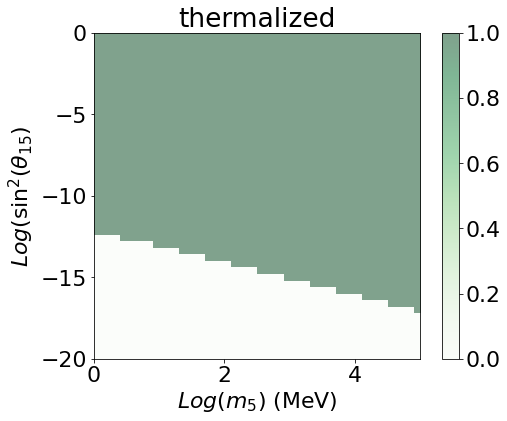

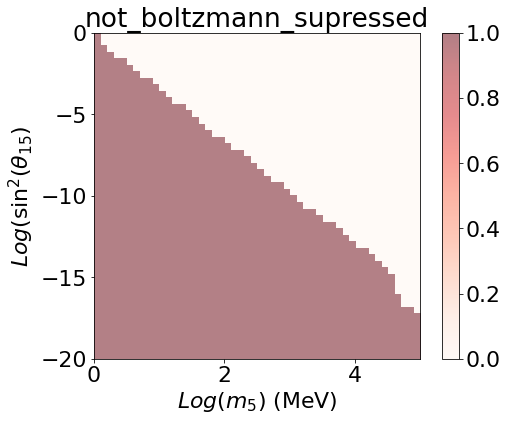

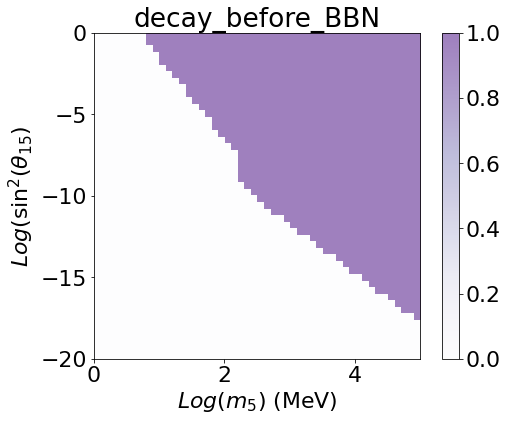

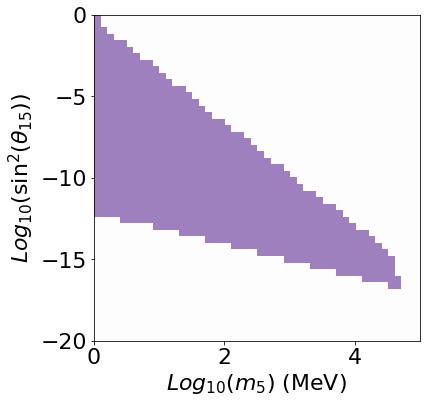

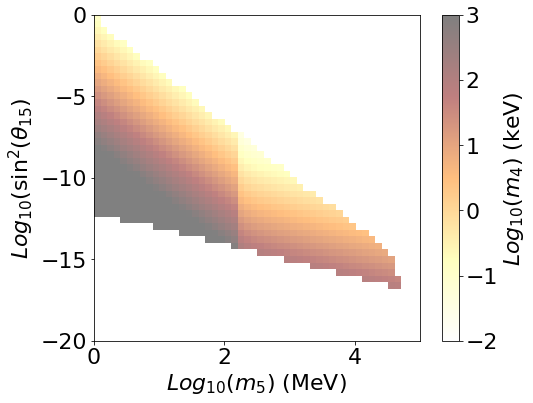

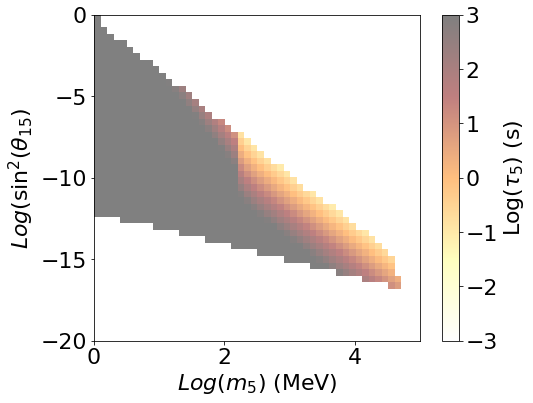

In [37]:
import matplotlib.pyplot as plt
import numpy as np

aspect = (m5_log_max- m5_log_min)/(2*theta_log_max- 2*theta_log_min)
keys = ['thermalized', 'not_boltzmann_supressed', 'decay_before_BBN']
colors = ['Greens', 'Reds', 'Purples']

for key, color in zip(keys, colors):
    plt.figure(figsize=(8,6))
    plt.imshow(sid_results[key], aspect=aspect, cmap=color, vmin=0, vmax=1, alpha=0.5, 
               extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
    # Add a colorbar to the plot
    plt.colorbar()
    plt.xlabel(r"$Log(m_5)$ (MeV)")
    plt.ylabel(r"$Log(\sin^2(\theta_{15})$")
    plt.title(key)
    plt.show()
    

plt.figure(figsize=(8,6))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['thermalized'])
plt.imshow(combined, aspect=aspect, cmap='Purples', alpha=0.5, vmin=0.1, vmax=1,
           extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
plt.xlabel(r"$Log_{10}(m_5)$ (MeV)")
plt.ylabel(r"$Log_{10}(\sin^2(\theta_{15}))$")
#plt.title("Thermalized and not boltzmann supressed")
plt.show()
    
plt.figure(figsize=(8,6))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['thermalized'])
m4s = combined*sid_results['m4_required']*10**3 #in keV
plt.imshow(np.log10(m4s+10**-5), aspect=aspect, cmap='afmhot_r', alpha=0.5, vmin=-2, vmax=3,
           extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
plt.xlabel(r"$Log_{10}(m_5)$ (MeV)")
plt.ylabel(r"$Log_{10}(\sin^2(\theta_{15})$")
#plt.title("Combined m_4")
plt.colorbar(label=r"$Log_{10}(m_4)$ (keV)")
plt.show()

plt.figure(figsize=(8,6))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['thermalized'])
lifetimes = combined*sid_results['lifetime'] #in keV
plt.imshow(np.log10(lifetimes+10**-10), aspect=aspect, cmap='afmhot_r', alpha=0.5, vmin=-3, vmax=3,
           extent=[m5_log_min, m5_log_max, 2*theta_log_min, 2*theta_log_max])
plt.xlabel(r"$Log(m_5)$ (MeV)")
plt.ylabel(r"$Log(\sin^2(\theta_{15})$")
#plt.title("Upper bound on lifetime")
plt.colorbar(label=r"Log($\tau_5$) (s)")
plt.show()

## Parameter scan across lifetimes and masses

In [31]:
m5_log_min, m5_log_max = np.log10(500), 4
m5_domain = np.logspace(m5_log_min, m5_log_max, 100)
lifetime_min, lifetime_max = -10, 0
lifetime_domain = np.logspace(lifetime_max, lifetime_min, 100)
dm_results = {
"m4_required":[]
}

start = time.time()
for lifetime in lifetime_domain:
    for key in dm_results:
        dm_results[key].append([])
    for m5 in m5_domain:
        dm_results['m4_required'][-1].append(ec.m4_dark_matter(m5, lifetime, 1, 1)) #relativistic DOFs don't matter, since Tf4=Tf5
        
print(time.time()-start)

0.023116111755371094


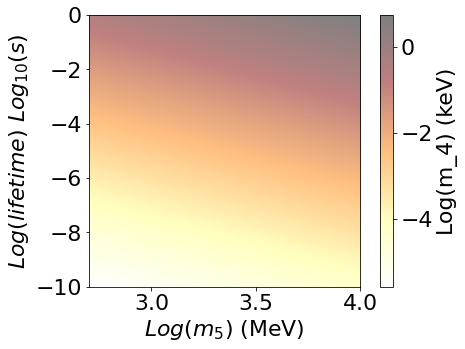

In [32]:
import matplotlib.pyplot as plt
import numpy as np

aspect = (m5_log_max-m5_log_min)/(lifetime_max-lifetime_min)
        
plt.figure(figsize=(8,6))
m4s = np.array(dm_results['m4_required'])*10**3
plt.imshow(np.log10(m4s), aspect=aspect, cmap='afmhot_r', alpha=0.5,
           extent=[m5_log_min, m5_log_max, lifetime_min, lifetime_max])
plt.xlabel(r"$Log(m_5)$ (MeV)")
plt.ylabel(r"$Log(lifetime)$ $Log_{10}(s)$")
plt.colorbar(label="Log(m_4) (keV)")
plt.show()

# Check individual equations

## Conversion to Omega_m

In [6]:
# CMB number sanity check: should be 411 photons per cm^-3 and Omega_cmb = 5.38*10*-5
# https://pdg.lbl.gov/2020/reviews/rpp2020-rev-cosmic-microwave-background.pdf
fint = 2*zeta(3)
gphoton=2
ndens_cmb = ec.fint_to_n(2*fint, Tcmb)
print("Number of photons per cm^-3 {}".format(ndens_cmb*MeVtoinversecm**3))
rho_cmb = gphoton*Tcmb**4*(np.pi**4/15.)/(2*np.pi**2)
print("omega_cmb = {}".format(ec.rho_to_omegahsq(rho_cmb)/h**2))

Number of photons per cm^-3 410.53331255544435
omega_cmb = 5.053161234954483e-05


In [7]:
# CnuB sanity check: see equation 25.2 here: https://pdg.lbl.gov/2019/reviews/rpp2019-rev-neutrinos-in-cosmology.pdf

g_nu = 2 #per flavor
fint = 1.5*zeta(3)
Tnu = Tcmb*(4./11)**(1/3.)
ndens_nu = ec.fint_to_n(g_nu*fint, Tnu)
print("Number of neutrinos per flavor per cm^-3 {}".format(ndens_nu*MeVtoinversecm**3))

sum_mnu = 93*eVtoMeV
print("omega_cnub h^2 for sum_mnu = 93eV {}".format(ec.rho_to_omegahsq(sum_mnu*ndens_nu)))

Number of neutrinos per flavor per cm^-3 111.9636306969394
omega_cnub h^2 for sum_mnu = 93eV 0.9900979224033691


## Relativistic DOFs

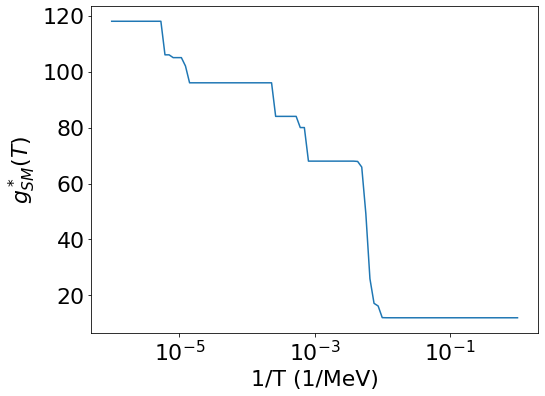

In [102]:
Tdom = np.logspace(6, 0, 100)
dofs = [ec.compute_SM_relativistic_dof(T) for T in Tdom]
plt.figure(figsize=(8,6))
plt.ylabel(r"$g^*_{SM}(T)$")
plt.xlabel("1/T (1/MeV)")
plt.semilogx(1/Tdom,dofs)
plt.show()

## Neutrino thermal scattering coefficients

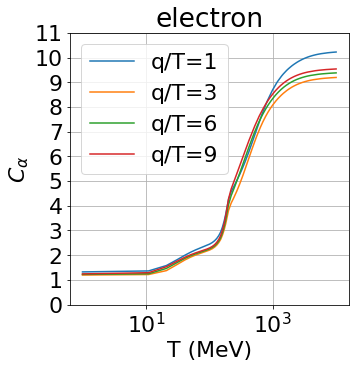

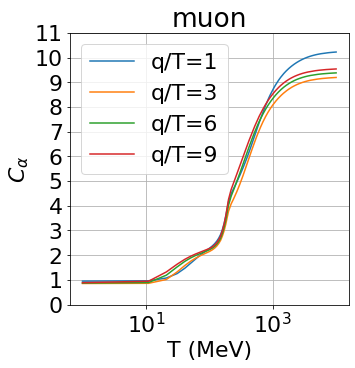

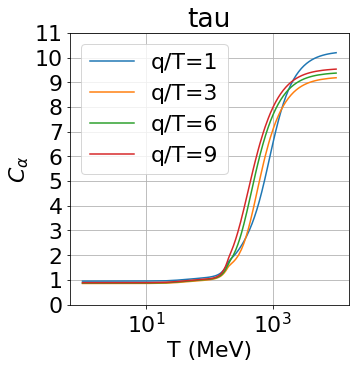

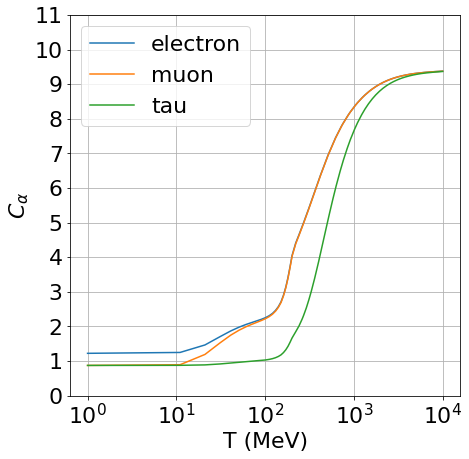

In [8]:
# Compare to figure 1 and 2 here: http://www.laine.itp.unibe.ch/neutrino-rate/imSigma.pdf

T_domain = np.linspace(1, 10**4, 10**3)
for flavor in ['electron', 'muon', 'tau']:
    plt.figure(figsize=(5,5))
    for qoverT in [1, 3, 6, 9]:
        plt.semilogx(T_domain, ec.scattering_coeffs_1Mev_to_5_GeV(T_domain, qoverT*T_domain, flavor), label='q/T={}'.format(qoverT))
    plt.ylabel(r"$C_\alpha$")
    plt.xlabel("T (MeV)")
    plt.title(flavor)
    #plt.xticks(np.logspace(min(np.log10(T_domain)), max(np.log10(T_domain)), 5))
    plt.yticks(np.arange(0, 12, 1))
    plt.grid()
    plt.legend()
    plt.show()

# Compare to figure 10 in Dodelson-Widrow production of sterile neutrino DM with non-trivial initial abundance

plt.figure(figsize=(7,7))
qoverT = 6
for flavor in ['electron', 'muon', 'tau']:
    plt.semilogx(T_domain, ec.scattering_coeffs_1Mev_to_5_GeV(T_domain, qoverT*T_domain, flavor), label=flavor)
plt.ylabel(r"$C_\alpha$")
plt.xlabel("T (MeV)")
plt.xticks(10**np.arange(0, 5, 1))
plt.yticks(np.arange(0, 12, 1))
plt.grid()
plt.legend()
plt.show()

## Active neutrino scattering rate: T>5 GeV

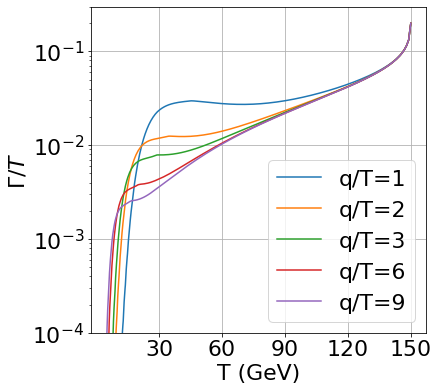

In [32]:
# Compare to fig. 6 in https://arxiv.org/pdf/1605.07720.pdf
T_domain = np.linspace(5*10**3, 150*10**3, 1000)
flavor='electron'

plt.figure(figsize=(6,6))
for qoverT in [1, 2, 3, 6, 9]:
    plt.semilogy(T_domain*10**-3, ec.active_scattering_rate(qoverT*T_domain, T_domain, flavor)/T_domain, label='q/T={}'.format(qoverT))
plt.ylabel(r"$\Gamma/T$")
plt.xlabel("T (GeV)")
plt.xticks(30*np.arange(1, 6, 1))
#plt.yticks(np.arange(0, 12, 1))
plt.ylim(10**-4, 3*10**-1)
plt.grid()
plt.legend()
plt.show()

## Combined Active Neutrino Scattering Rate

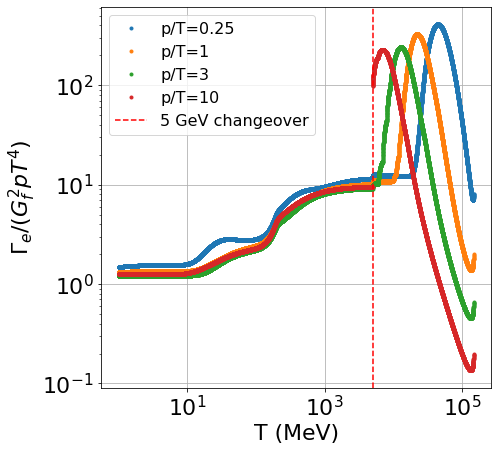

In [42]:
# Compare to fig. 6 in https://arxiv.org/pdf/1605.07720.pdf
T_domain = np.logspace(0, np.log10(149*10**3), 10**4)
#T_domain = np.logspace(3, 3.7, 10**3)
flavor='electron'

plt.figure(figsize=(7,7))
for poverT in [0.25, 1, 3, 10]:
    p_domain = poverT*T_domain
    plt.loglog(T_domain, ec.active_scattering_rate(p_domain, T_domain, flavor)/(Gf**2*p_domain*T_domain**4),  '.', label='p/T={}'.format(poverT))
plt.ylabel(r"$\Gamma_e / (G_f^2 p T^4)$")
plt.xlabel("T (MeV)")
plt.axvline(5*10**3, c='r', ls='--', label="5 GeV changeover")
#plt.xticks(np.logspace(0, 5, 6))
plt.grid()
plt.legend(fontsize=16)
plt.show()

## h(T,p)

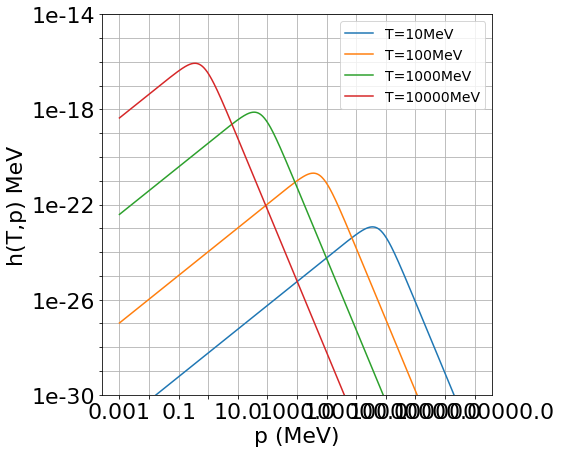

In [3]:
theta=np.sqrt(7*10**-11)
ms=0.007
flavor='electron'
antineutrino=False
momenta = np.logspace(-3, 9, 1000)

plt.figure(figsize=(7,7))
for T in [10**1, 10**2, 10**3, 10**4]:
    plt.loglog(momenta, ec.h(momenta, T, theta, ms, flavor, antineutrino, merle_simplification=True), label="T={}MeV".format(T))
plt.legend(fontsize=14)
plt.ylabel("h(T,p) MeV")
plt.xlabel("p (MeV)")
yticks=np.logspace(-14, -30, 17)
plt.yticks(ticks=yticks, labels=[str(ytick) if i % 4 == 0 else '' for i, ytick in enumerate(yticks)])
xticks=np.logspace(-3, 9, 13)
plt.xticks(ticks=xticks, labels=[str(xtick) if i % 2 == 0 else '' for i, xtick in enumerate(xticks)])
plt.grid()
plt.ylim(10**-30, 10**-14)
plt.show()

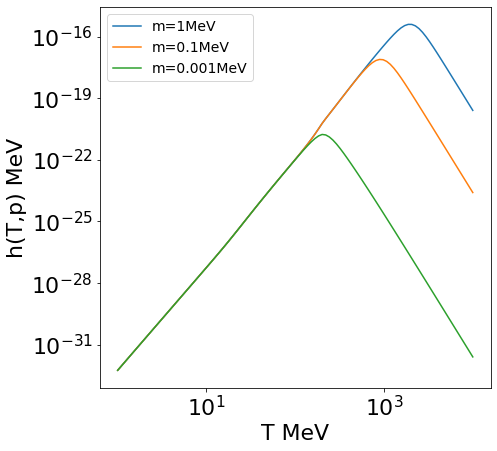

In [16]:
theta=np.sqrt(7*10**-11)
ms=0.07
flavor='electron'
antineutrino=False

plt.figure(figsize=(7,7))
poverT = 1
Tdomain = np.logspace(4, 0, 100)
    for T in Tdomain:
        hresults.append(ec.h(poverT*T, T, theta, ms, flavor, antineutrino, merle_simplification=True))
    plt.loglog(Tdomain, hresults, label="m={}MeV".format(ms))
plt.legend(fontsize=14)
plt.ylabel("h(T,p) MeV")
plt.xlabel("T MeV")
plt.show()

## Check DW SID rate vs the more detailed production rate

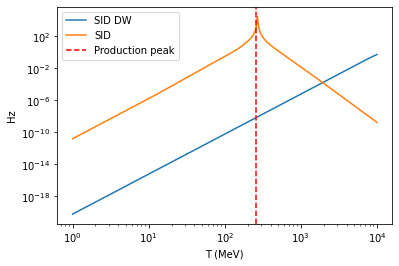

In [7]:
params={
"m4": 7*10**-3, #MeV
"theta": 0.5*np.sqrt(7*10**-11),
}

T = np.logspace(0, 4, 500)

sid_DW = ec.SID_rate_DW(T, params["theta"], params["m4"])
sid = ec.SID_rate(T, params["theta"], params["m4"], 'electron', antineutrino=False)

plt.loglog(T, sid_DW*MeVtoHz, label='SID DW')
plt.loglog(T, sid*MeVtoHz, label="SID")
plt.axvline(ec.Tmax(params["m4"]), c='r', ls='--', label="Production peak")
plt.ylabel("Hz")
plt.xlabel("T (MeV)")
plt.legend()
plt.show()

## Generic Production Rate

In [8]:
def SID_rate_integrated(T, theta, m5, flavor, pmin=0.01,pmax=10):
    if np.isscalar(T):
        integrand = lambda p: ec.SID_rate(p, T, theta, m5, flavor)*p**2/(np.exp(p/T)+1)
        result, err = quad(integrand, pmin*T, pmax*T)
        return result/(1.5*T**3*zeta(3))
    else:
        rates = []
        for Ti in T:
            integrand = lambda p: ec.SID_rate(p, Ti, theta, m5, flavor)*p**2/(np.exp(p/Ti)+1)
            result, err = quad(integrand, pmin*Ti, pmax*Ti)
            rates.append(result/(1.5*Ti**3*zeta(3)))
        return np.array(rates)
            

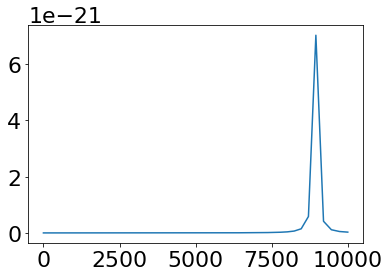

In [36]:
pdom = np.logspace(-2, 4, 500)
T=1
plt.plot(pdom, ec.SID_rate(pdom, T, params["theta"], params["m5"], 'electron'))
plt.show()

In [41]:
params={
"m5": 10**2, #MeV
"theta": 10**-5,
}

T = np.logspace(1.95, 5, 100)

#sid = ec.SID_rate(ec.avg_p(T), T, params["theta"], params["m5"], 'electron')
sid_integrated = SID_rate_integrated(T, params["theta"], params["m5"], 'electron', pmin=0.1, pmax=10**3)

plt.figure(figsize=(8,6))
plt.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate')
#plt.loglog(1/T, sid*MeVtoHz, label="SID")
plt.loglog(1/T, sid_integrated*MeVtoHz, label=r"$\Gamma_{SID}$")

thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**5, 1, params["theta"], params["m5"], 'electron', antineutrino=False, num_T=1000)
if thermalized:
     plt.axvline(1/T_thermal, c='b', ls='--', label=r"$\nu_5$ thermalized")
     plt.axvline(1/T_freezeout, c='r', ls='--', label=r"$T_{f4/5}$ (freezeout)")
#plt.axvline(1/ec.Tmax(params["m5"]), c='r', ls='--', label="Production peak")
plt.axvline(1/params["m5"], c='g', ls='--', label="m5")
plt.ylabel("Hz")
plt.xlabel("1/T (1/MeV)")
plt.legend(fontsize=12)
plt.title(r"$m_5={}MeV, \theta={}$".format(params['m5'], params['theta']))
plt.show()

NameError: name 'SID_rate_integrated' is not defined

## Lifetimes

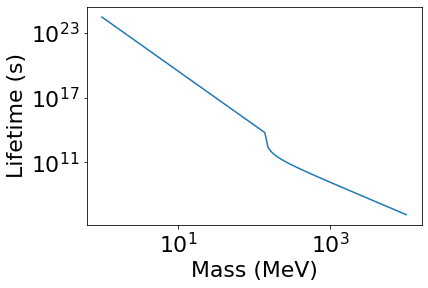

In [37]:
m_domain = np.logspace(0, 4, 100)
theta = 10**-10
lifetimes = [ec.lifetime(m, theta) for m in m_domain]
plt.loglog(m_domain, lifetimes)
plt.ylabel("Lifetime (s)")
plt.xlabel("Mass (MeV)")
plt.show()

## Check the lepton potential pre-factors

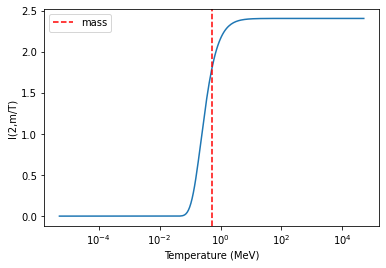

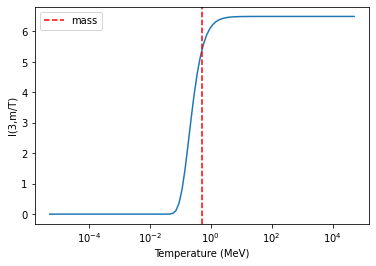

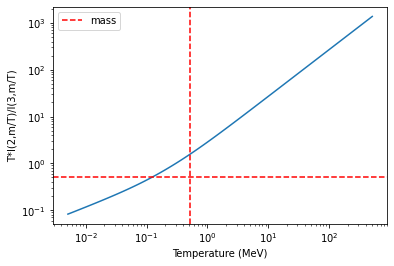

In [11]:
factors = []
T_domain = m_e*np.logspace(-5, 5, 251)
for T in T_domain:
    factors.append(ec.lepton_integral_interp(2, m_e/T))
plt.semilogx(T_domain, factors)
plt.ylabel("I(2,m/T)")
plt.xlabel("Temperature (MeV)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.legend()
plt.show()


factors = []
T_domain = m_e*np.logspace(-5, 5, 100)
for T in T_domain:
    factors.append(ec.lepton_integral_interp(3, m_e/T))
plt.figure()
plt.semilogx(T_domain, factors)
plt.ylabel("I(3,m/T)")
plt.xlabel("Temperature (MeV)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.legend()
plt.show()

factors = []
plt.figure()

# The average energy should converge to the mass: but it doesn't
# because the integral results just get too small. 
T_domain = m_e*np.logspace(-2, 3, 100)
for T in T_domain:
    factors.append(T*ec.lepton_integral_interp(3, m_e/T)/ec.lepton_integral_interp(2, m_e/T))
plt.loglog(T_domain, factors)

plt.xlabel("Temperature (MeV)")
plt.ylabel("T*I(2,m/T)/I(3,m/T)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.axhline(m_e, ls='--', c='r')
plt.legend()
plt.show()

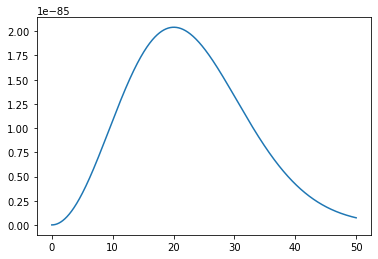

In [36]:
n=2
x=200
y_dom = np.linspace(0.001,50, 1000)
plt.plot(y_dom, y_dom**n/(np.exp(np.sqrt(x**2 + y_dom**2))-1))